## Gold time series analysis daily and monthly
This single notebook is self-contained and uses  attached monthly CSV. It includes clear, step-by-step explanations and code cells for (1) trend/seasonality via ACF/PACF and STL, (2) long-term cycle, regime and volatility analysis, and (3) baseline models (SARIMA and Holt–Winters) with benchmarking. It also supports daily data if you provide the daily CSV locally.

## Setup and imports

In [29]:
# Cell: imports and settings
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

plt.style.use("seaborn-v0_8")
pd.set_option("display.float_format", lambda v: f"{v:,.4f}")


## Data loading

This cell is responsible for importing the raw gold price data from CSV files (monthly and daily) and preparing it for analysis. It defines helper functions to ensure the datasets are consistently formatted and ready for time series modeling:

File paths: MONTHLY_PATH and DAILY_PATH specify the locations of the monthly and daily gold CSV files. The daily path can be updated if the file is stored elsewhere.

_standardize(df): A utility function that cleans and standardizes the dataset by:

Converting column names to lowercase for consistency.

Setting the date column as the index and sorting chronologically.

Converting numeric fields (open, high, low, close, volume) to proper numeric types, coercing invalid entries to NaN.

Dropping rows that are completely empty.

load_monthly(path): Reads the monthly CSV file using a semicolon separator, parses the Date column into datetime objects, and applies _standardize to return a clean DataFrame.

load_daily(path): Similar to load_monthly, but designed for daily data files. It also parses dates and standardizes the structure.

Loading and validation:

The monthly dataset is loaded into df_m, and the close price series (close_m) is extracted. The code prints the number of rows and the date range to confirm successful loading.

For daily data, the code checks if the file exists. If found, it loads the dataset into df_d, extracts the close series (close_d), and prints summary information. If not found, it prints a message indicating that daily analysis will be skipped.

This preprocessing step ensures that both monthly and daily datasets are clean, consistent, and indexed by date, which is essential for subsequent time series analysis (ACF/PACF, regime detection, and forecasting models).

In [30]:
# Cell: data loaders
MONTHLY_PATH = "./XAU_1Month_data.csv"
DAILY_PATH = "./XAU_1d_data.csv"  # change this if your daily file is elsewhere

def _standardize(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardize columns: lowercase names, datetime index, numeric conversion.
    """
    df.columns = [c.strip().lower() for c in df.columns]
    df = df.set_index("date").sort_index()
    for c in ["open", "high", "low", "close", "volume"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(how="all")
    return df

def load_monthly(path: str) -> pd.DataFrame:
    """
    Load monthly gold CSV with semicolon separator; parses Date column.
    """
    df = pd.read_csv(path, sep=";", parse_dates=["Date"], dayfirst=False)
    return _standardize(df)

def load_daily(path: str) -> pd.DataFrame:
    """
    Load daily gold CSV (semicolon separator by default). Adjust if needed.
    """
    df = pd.read_csv(path, sep=";", parse_dates=["Date"], dayfirst=False)
    return _standardize(df)

# Load monthly
df_m = load_monthly(MONTHLY_PATH)
close_m = df_m["close"].dropna()
print("Monthly rows:", len(close_m), "range:", close_m.index.min(), "→", close_m.index.max())

# Try to load daily; if not available, skip
df_d, close_d = None, None
if os.path.exists(DAILY_PATH):
    df_d = load_daily(DAILY_PATH)
    close_d = df_d["close"].dropna()
    print("Daily rows:", len(close_d), "range:", close_d.index.min(), "→", close_d.index.max())
else:
    print("Daily file not found at", DAILY_PATH, "- daily analysis will be skipped.")


Monthly rows: 257 range: 2004-06-01 00:00:00 → 2025-12-01 00:00:00
Daily rows: 5462 range: 2004-06-11 00:00:00 → 2025-12-01 00:00:00


## Helper functions for Stationarity, Diagnostics, and Forecast Evaluation
This cell defines a set of utility functions that support statistical diagnostics and model benchmarking in the gold price forecasting workflow:

prepare_stationary(series, use_log=True, diff_order=1): Transforms a raw time series into a stationary form, which is required for reliable autocorrelation analysis and ARIMA-type models. It optionally applies a logarithmic transformation to stabilize variance and differencing to remove trends.

acf_pacf_plots(series, max_lag, title_prefix): Generates side-by-side plots of the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF). These plots help identify lag structures, seasonal patterns, and guide the selection of ARIMA model orders.

stl_decompose(series, period, title): Performs Seasonal-Trend decomposition using Loess (STL). This separates the series into trend, seasonal, and residual components, allowing clear visualization of long-term cycles and recurring seasonal effects. The period parameter is set according to data frequency (e.g., 12 for monthly, 365 or 7 for daily).

mape(y_true, y_pred): Calculates the Mean Absolute Percentage Error (MAPE), a scale-independent metric that expresses forecast error as a percentage of actual values.

evaluate_forecast(test, pred): Computes three key accuracy metrics — Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and MAPE — to benchmark model performance. These metrics provide complementary views of forecast accuracy, balancing absolute error, squared error sensitivity, and percentage error.

Together, these helpers streamline the analysis pipeline by ensuring data is properly prepared for statistical tests, enabling clear visualization of autocorrelation and seasonality, and providing standardized metrics for comparing forecasting models.

In [31]:
# Cell: helpers for stationarity, plots, metrics
def prepare_stationary(series: pd.Series, use_log: bool = True, diff_order: int = 1) -> pd.Series:
    """
    Transform series toward stationarity via optional log and differencing.
    Use this for ACF/PACF where stationarity is needed.
    """
    s = series.copy()
    if use_log:
        s = np.log(s)
    for _ in range(diff_order):
        s = s.diff()
    return s

def acf_pacf_plots(series: pd.Series, max_lag: int, title_prefix: str = ""):
    """
    Plot ACF and PACF for a (preferably stationary) series.
    """
    s = series.dropna()
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(s, lags=max_lag, ax=axes[0])
    plot_pacf(s, lags=max_lag, ax=axes[1], method="ywm")
    axes[0].set_title(f"{title_prefix} ACF")
    axes[1].set_title(f"{title_prefix} PACF")
    plt.tight_layout()
    plt.show()

def stl_decompose(series: pd.Series, period: int, title: str):
    """
    STL decomposition to visualize trend and seasonality. Choose period per frequency.
    - Monthly: 12
    - Daily: 365 (yearly), or 7 (weekly), depending on hypothesis
    """
    s = series.dropna()
    res = STL(s, period=period, robust=True).fit()
    fig = res.plot()
    fig.set_size_inches(10, 6)
    fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()
    return res

def mape(y_true: pd.Series, y_pred: pd.Series) -> float:
    """
    Mean Absolute Percentage Error in percent.
    """
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100.0

def evaluate_forecast(test: pd.Series, pred: pd.Series) -> dict:
    """
    Compute MAE, RMSE, and MAPE.
    """
    mae = mean_absolute_error(test, pred)
    rmse = np.sqrt(np.mean((np.array(test) - np.array(pred))**2))
    mp = mape(test, pred)
    return {"MAE": mae, "RMSE": rmse, "MAPE": mp}


## 1. Trend and seasonality analysis using ACF/PACF
This cell performs statistical diagnostics to uncover the underlying structure of the monthly gold price series:

STL decomposition (Seasonal-Trend decomposition using Loess): The series is decomposed into three components — trend, seasonality, and residuals.

The period=12 parameter reflects yearly seasonality in monthly data (12 months per cycle).

The trend component highlights long-term upward or downward movements.

The seasonal component captures recurring annual patterns.

The residual component isolates irregular fluctuations not explained by trend or seasonality.

Stationarity preparation: To make the series suitable for autocorrelation analysis, the closing prices are log-transformed (to stabilize variance) and differenced once (to remove trend). This produces a stationary series (close_m_stat).

ACF and PACF plots:

The Autocorrelation Function (ACF) shows correlations between the series and its own lagged values, helping detect repeating cycles or seasonal dependencies.

The Partial Autocorrelation Function (PACF) isolates the direct correlation at each lag, guiding the choice of autoregressive (AR) terms in ARIMA/SARIMA models.

Here, lags up to 48 months (~4 years) are plotted to reveal both short-term and longer seasonal dependencies.

Together, these diagnostics provide a clear view of the gold market’s cyclical behavior, seasonal influences, and the lag structure needed for building robust forecasting models.

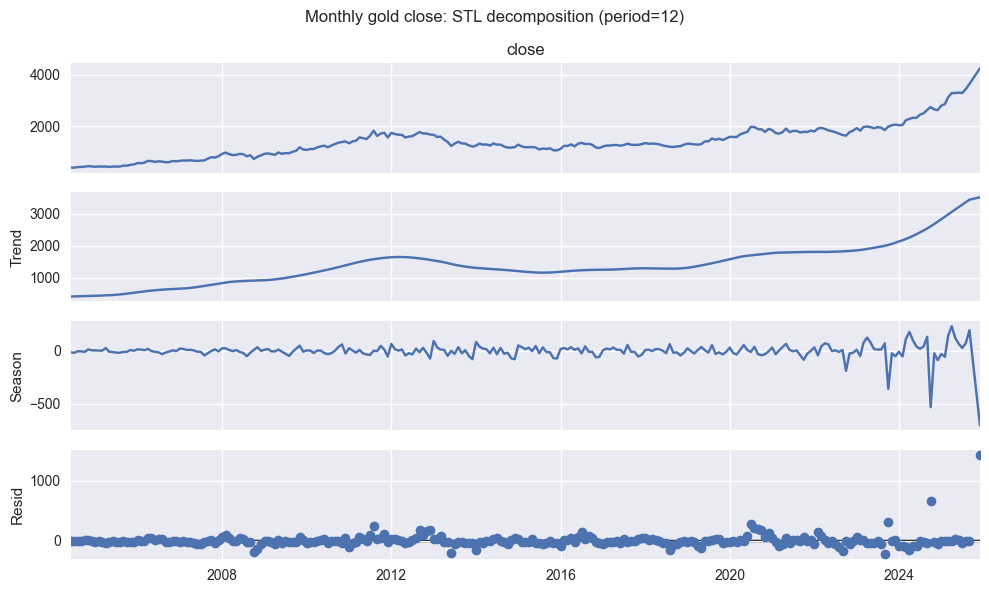

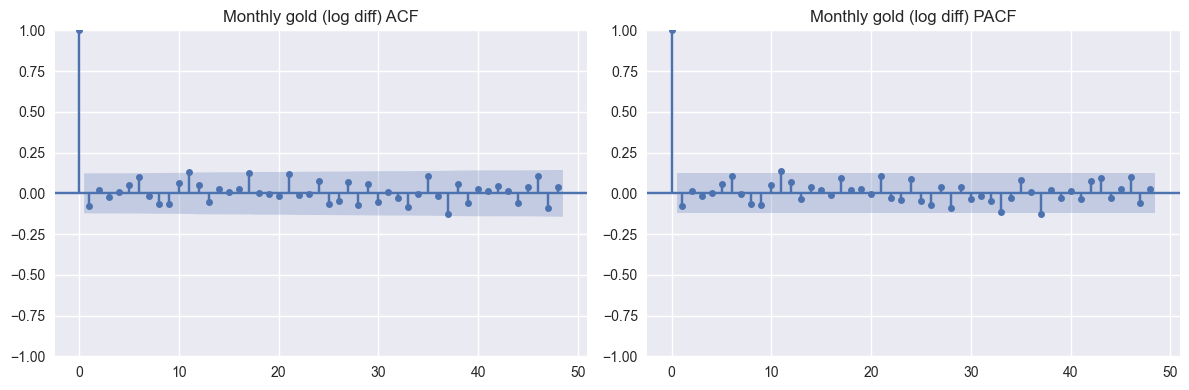

In [32]:
# Cell: monthly STL and ACF/PACF
# STL: yearly seasonality expected in monthly data (period=12)
_ = stl_decompose(close_m, period=12, title="Monthly gold close: STL decomposition (period=12)")

# ACF/PACF: use log-differenced series for stationarity
close_m_stat = prepare_stationary(close_m, use_log=True, diff_order=1)
acf_pacf_plots(close_m_stat, max_lag=48, title_prefix="Monthly gold (log diff)")


This cell examines the daily gold price series (if available) to uncover cyclical patterns and lag dependencies that inform forecasting model design:

STL decomposition (Seasonal-Trend decomposition using Loess):

The series is decomposed into trend, seasonal, and residual components.

A yearly period (period=365) is specified to capture annual seasonality in daily data.

The trend component highlights long-term upward or downward movements.

The seasonal component reveals recurring yearly cycles.

The residual captures irregular fluctuations not explained by trend or seasonality.

Stationarity preparation:

The raw daily closing prices are log-transformed to stabilize variance.

A first difference is applied to remove trend and achieve approximate stationarity.

This stationary series (close_d_stat) is suitable for autocorrelation analysis.

ACF and PACF plots:

The Autocorrelation Function (ACF) shows correlations between the series and its lagged values, helping detect repeating cycles or seasonal dependencies.

The Partial Autocorrelation Function (PACF) isolates direct correlations at each lag, guiding the choice of autoregressive (AR) terms in ARIMA/SARIMA models.

Lags up to 90 days (~3 months) are plotted to reveal both short-term and medium-term dependencies.

Conditional execution: If the daily dataset is not found, the analysis is skipped gracefully with a message, ensuring the notebook remains robust.

This diagnostic step provides a clear view of daily gold price behavior, highlighting annual seasonality, short-term autocorrelation, and the lag structure needed for building accurate forecasting models.

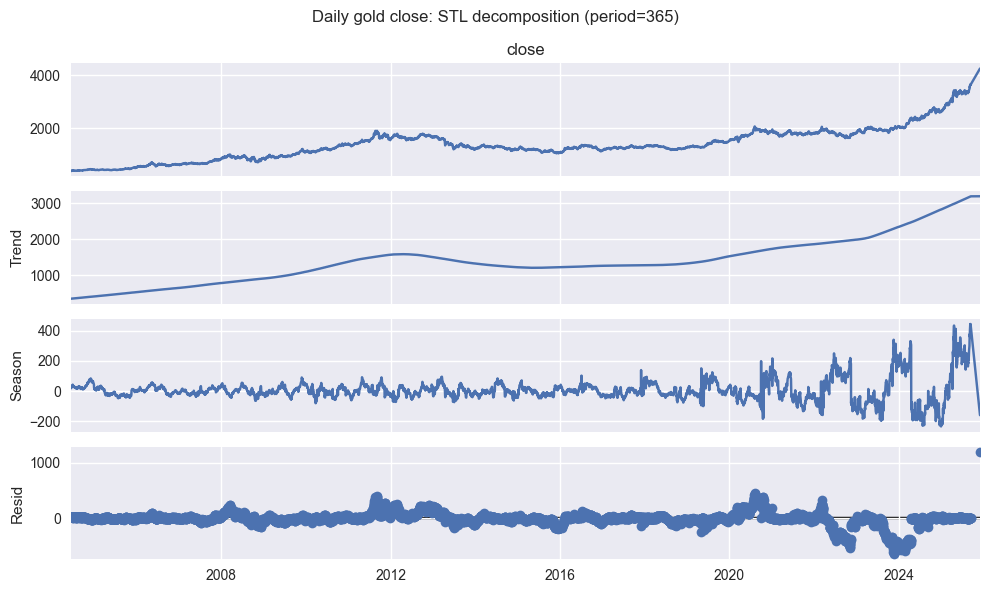

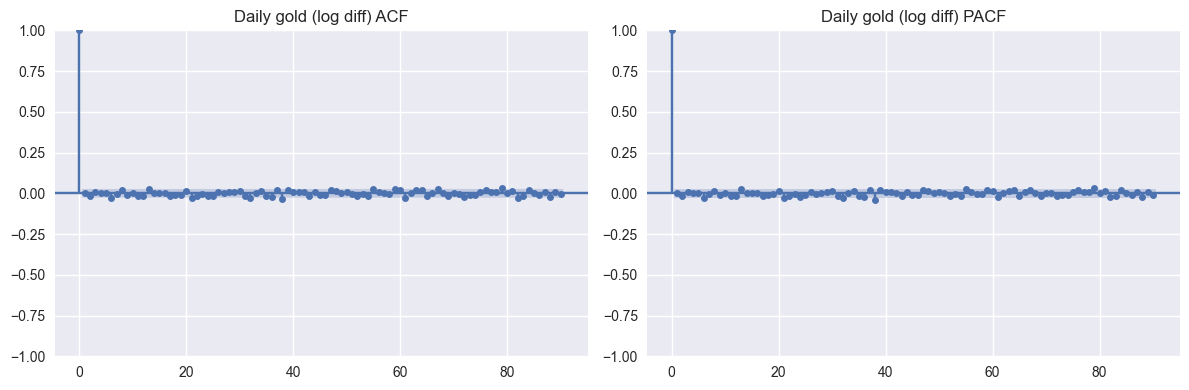

In [33]:
# Cell: daily STL and ACF/PACF (skip if daily file missing)
if close_d is not None:
    # Consider yearly seasonality (365) or weekly (7); we visualize yearly first
    _ = stl_decompose(close_d, period=365, title="Daily gold close: STL decomposition (period=365)")
    close_d_stat = prepare_stationary(close_d, use_log=True, diff_order=1)
    acf_pacf_plots(close_d_stat, max_lag=90, title_prefix="Daily gold (log diff)")
else:
    print("Daily analysis skipped: no daily dataset loaded.")


## 2. Long-term cycles, regime shifts, and volatility patterns
We examine slow-moving trend regimes with rolling means, dispersion changes with rolling std, and volatility clustering via realized volatility from log returns. We also flag extremes with rolling z-scores as a simple regime indicator.

This cell defines and applies utilities to study long-term cycles, regime shifts, and volatility clustering in the gold price series:

rolling_stats(series, windows): Computes rolling means and rolling standard deviations over specified windows.

Rolling means act as proxies for regime trends, showing how the average price evolves over time.

Rolling standard deviations highlight changes in dispersion, useful for spotting volatility regimes.

Suggested windows:

Monthly data → 12 and 24 (1 year, 2 years).

Daily data → 30 and 90 (1 month, 3 months).

realized_vol(series, window): Estimates realized volatility by calculating the rolling standard deviation of log returns, scaled by the square root of the window length. This captures volatility clustering, where periods of high volatility tend to follow each other.

plot_regime_vol(series, windows, title): Produces a composite visualization with three panels:

Price level (raw closing prices).

Rolling means (regime proxies) to highlight long-term cycles.

Rolling std and realized volatility to reveal volatility patterns and clusters. This allows simultaneous inspection of price trends, regime shifts, and volatility dynamics.

zscore_regimes(series, window, threshold): Calculates rolling z-scores to flag outsized deviations from the local mean.

A regime_flag is set to 1 when the absolute z-score exceeds the threshold (default = 1.0).

This provides a simple indicator of potential regime shifts or extreme events relative to recent history.

Application to monthly data: The functions are applied to the monthly gold closing price series with 12- and 24-month windows.

The plot shows how regimes and volatility evolve over time.

The z-score output (reg_m.tail()) lists the most recent flagged regimes, helping identify unusual market conditions.

This analysis step is crucial for understanding how gold prices transition between regimes (e.g., bull vs bear cycles) and how volatility clusters around major economic or geopolitical events.

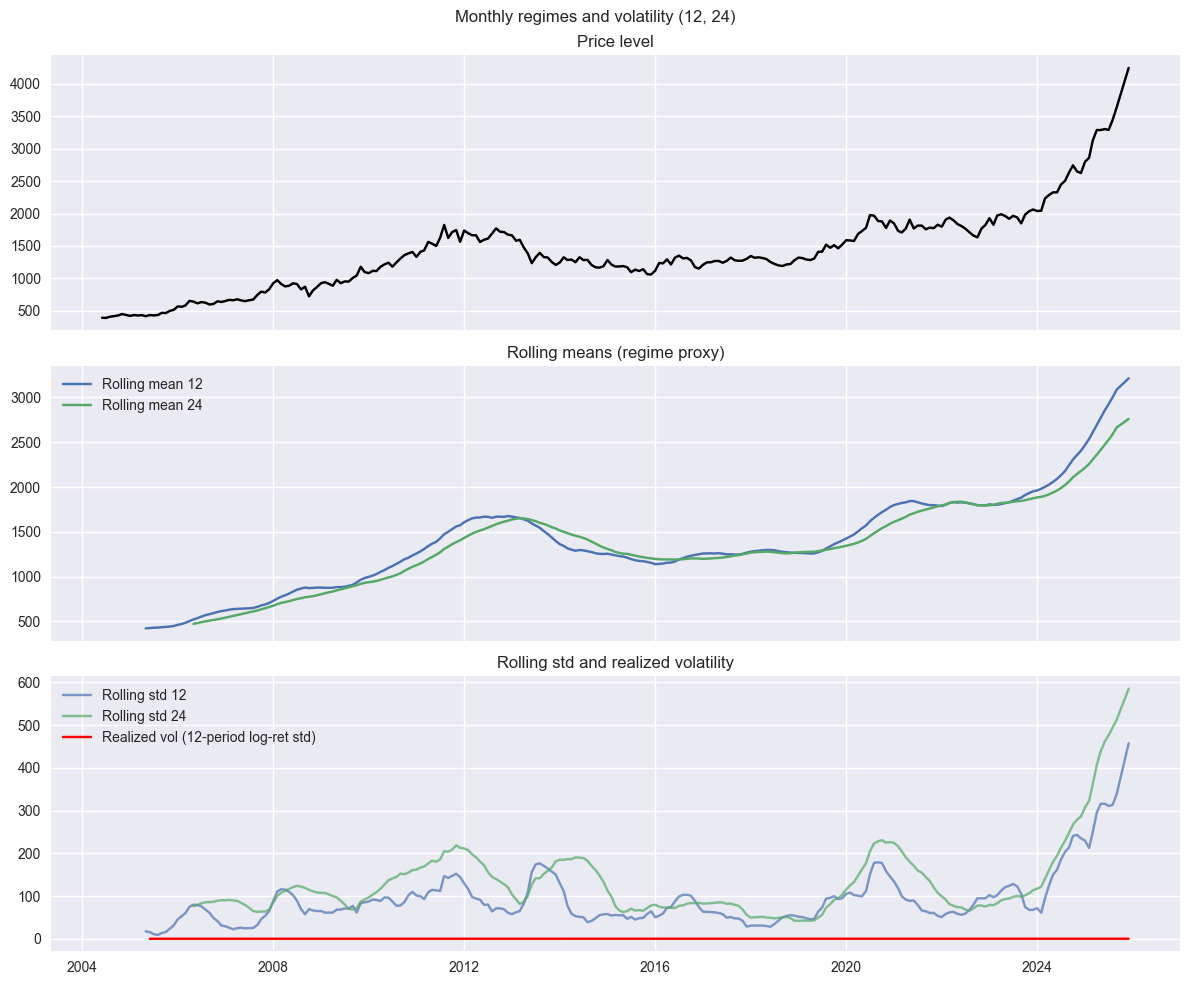

,value,zscore,regime_flag
date,,,
2025-06-01,"3,302.9200",1.7993,1
2025-07-01,"3,290.6800",1.5988,1
2025-08-01,"3,448.1600",1.7315,1
2025-09-01,"3,642.5600",1.9037,1
2025-12-01,"4,246.3100",2.5403,1


In [34]:
# Cell: regime & volatility utilities and plots
def rolling_stats(series: pd.Series, windows):
    """
    Compute rolling mean/std over specified windows.
    - Monthly suggestion: (12, 24) ~ 1y, 2y
    - Daily suggestion: (30, 90) ~ 1m, 3m
    """
    df = pd.DataFrame({"value": series})
    for w in windows:
        df[f"roll_mean_{w}"] = series.rolling(w).mean()
        df[f"roll_std_{w}"] = series.rolling(w).std()
    return df

def realized_vol(series: pd.Series, window: int):
    """
    Realized volatility: rolling std of log returns scaled by sqrt(window).
    """
    log_ret = np.log(series).diff()
    vol = log_ret.rolling(window).std() * np.sqrt(window)
    return vol

def plot_regime_vol(series: pd.Series, windows, title: str):
    """
    Composite visualization: price, rolling means (regimes), rolling std & realized vol (vol clustering).
    """
    df = rolling_stats(series, windows=windows)
    vol_window = windows[0] if isinstance(windows, (list, tuple)) else int(windows)
    vol = realized_vol(series, window=vol_window)

    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    axes[0].plot(series.index, series.values, label="Close", color="black")
    axes[0].set_title("Price level")

    for w in windows:
        axes[1].plot(df.index, df[f"roll_mean_{w}"], label=f"Rolling mean {w}")
    axes[1].legend()
    axes[1].set_title("Rolling means (regime proxy)")

    for w in windows:
        axes[2].plot(df.index, df[f"roll_std_{w}"], label=f"Rolling std {w}", alpha=0.7)
    axes[2].plot(vol.index, vol.values, label=f"Realized vol ({vol_window}-period log-ret std)", color="red")
    axes[2].legend()
    axes[2].set_title("Rolling std and realized volatility")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def zscore_regimes(series: pd.Series, window: int = 24, threshold: float = 1.0) -> pd.DataFrame:
    """
    Rolling z-scores to flag outsized deviations (simple regime shift indicator).
    """
    roll_mean = series.rolling(window).mean()
    roll_std = series.rolling(window).std()
    z = (series - roll_mean) / roll_std
    regimes = (np.abs(z) > threshold).astype(int)
    return pd.DataFrame({"value": series, "zscore": z, "regime_flag": regimes})

# Monthly regime & volatility
plot_regime_vol(close_m, windows=(12, 24), title="Monthly regimes and volatility (12, 24)")
reg_m = zscore_regimes(close_m, window=24, threshold=1.0)
reg_m.tail()


## Daily Gold Regime and Volatility Analysis
This cell investigates regime shifts and volatility clustering in the daily gold price series (if available):

Composite visualization (plot_regime_vol)

    Plots the raw daily closing prices.
    
    Adds rolling means (30‑day and 90‑day windows) as proxies for short‑term and medium‑term regimes. These highlight how the average price evolves and help detect regime changes.
    
    Shows rolling standard deviations and realized volatility (from log returns) to capture volatility clustering, where periods of high volatility tend to follow each other.

Regime detection via z‑scores (zscore_regimes)

    Computes rolling z‑scores over a 90‑day window.
    
    Flags extreme deviations (absolute z‑score > 1.0) as potential regime shifts.
    
    Produces a DataFrame with the latest values (reg_d.tail()), showing whether the market is in a normal state or flagged as an extreme regime.

Conditional execution 
    If the daily dataset is not found, the analysis is skipped gracefully with a message, ensuring the notebook runs without errors.

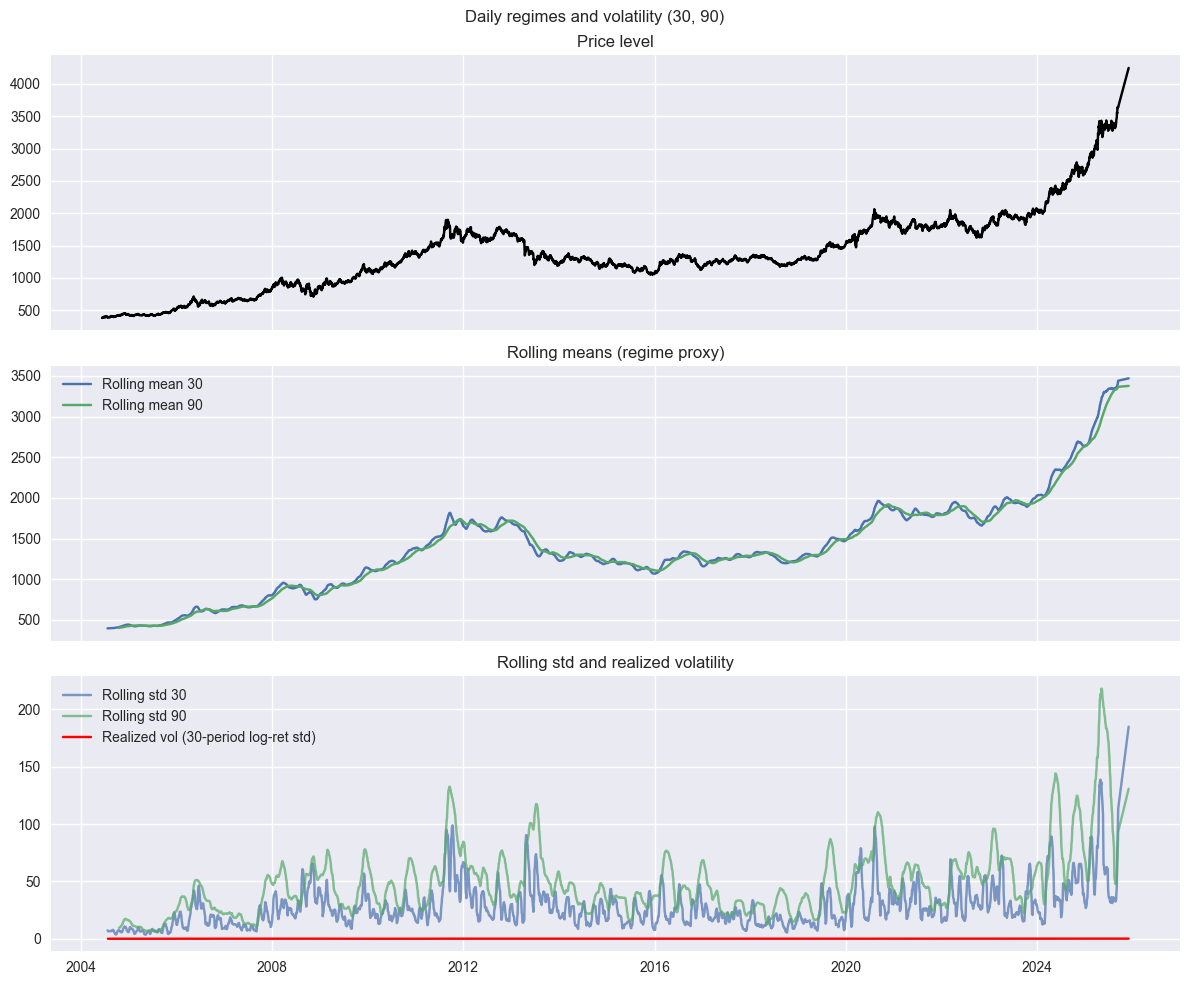

In [35]:
# Cell: daily regime & volatility (skip if missing)
if close_d is not None:
    plot_regime_vol(close_d, windows=(30, 90), title="Daily regimes and volatility (30, 90)")
    reg_d = zscore_regimes(close_d, window=90, threshold=1.0)
    reg_d.tail()
else:
    print("Daily regime/volatility skipped: no daily dataset loaded.")


## 3. Baseline models: SARIMA and Holt–Winters
We build baselines with SARIMA and Holt–Winters. Monthly models use seasonal period 12. For daily, we start with weekly seasonality (7). We evaluate using MAE, RMSE, and MAPE, and plot forecasts versus actuals.

This cell defines utility functions to build and evaluate baseline forecasting models for the gold price series, using both statistical approaches and visualization:

time_split(series, test_size): Splits the time series chronologically into training and testing sets, reserving the last N observations for out‑of‑sample evaluation. This ensures forecasts are validated on unseen future data.

fit_sarima_forecast(train, test, order, seasonal_order): Fits a Seasonal ARIMA (SARIMA) model with specified autoregressive (p), differencing (d), moving average (q), and seasonal (P, D, Q, s) parameters.

    The model captures both short‑term dynamics and recurring seasonal patterns.

    Forecasts are generated for the test horizon and aligned with the test index.

fit_holt_winters_forecast(train, test, trend, seasonal, seasonal_periods): Implements Holt–Winters Triple Exponential Smoothing, which models level, trend, and seasonality.

    Supports additive or multiplicative components depending on the data’s variance behavior.

    Produces forecasts for the test horizon, aligned with actual dates.

plot_forecasts(train, test, preds, title): Creates a comparative plot showing:

    Training data (gray).

    Actual test values (black).

    Forecasts from multiple models (dashed lines). This visual comparison highlights how well each baseline model tracks actual market movements.

Together, these functions provide a structured way to benchmark forecasting accuracy, compare statistical baselines, and visualize performance before moving on to more advanced machine learning or hybrid models.

In [36]:
# Cell: baselines and plotting
def time_split(series: pd.Series, test_size: int):
    """
    Chronological train/test split by last N points.
    """
    train = series.iloc[:-test_size]
    test = series.iloc[-test_size:]
    return train, test

def fit_sarima_forecast(train: pd.Series, test: pd.Series,
                        order=(1,1,1), seasonal_order=(0,1,1,12)):
    """
    SARIMA baseline with given (p,d,q) and (P,D,Q,s).
    """
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    pred = res.get_forecast(steps=len(test)).predicted_mean
    pred.index = test.index
    return res, pred

def fit_holt_winters_forecast(train: pd.Series, test: pd.Series,
                              trend="add", seasonal="add", seasonal_periods=12):
    """
    Holt–Winters (Triple Exponential Smoothing); try 'add' vs 'mul' seasonality.
    """
    hw = ExponentialSmoothing(train, trend=trend, seasonal=seasonal,
                              seasonal_periods=seasonal_periods, initialization_method="estimated")
    res = hw.fit()
    pred = res.forecast(len(test))
    pred.index = test.index
    return res, pred

def plot_forecasts(train: pd.Series, test: pd.Series, preds: dict, title: str):
    """
    Comparative plot for multiple forecast series.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train.values, label="Train", color="gray")
    plt.plot(test.index, test.values, label="Test (Actual)", color="black")
    for label, series in preds.items():
        plt.plot(series.index, series.values, label=label, linestyle="--")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


## Monthly Baseline Forecasting and Benchmarking (SARIMA vs Holt–Winters)
This cell builds and evaluates baseline forecasting models for the monthly gold price series, using the last 24 months as the test set:

Train/Test Split: 
    The series is divided chronologically, with the most recent 24 months reserved for out‑of‑sample evaluation. This ensures forecasts are validated against unseen data.

SARIMA Model: 
    A Seasonal ARIMA model is fit with parameters (p,d,q) = (1,1,1) and seasonal (P,D,Q,s) = (0,1,1,12).

    Captures short‑term autoregressive and moving average dynamics.

    Models yearly seasonality (s=12) in monthly data.

    Produces forecasts aligned with the test horizon.

Holt–Winters Model: 
    A Triple Exponential Smoothing model with additive trend and seasonality is fit.

    Decomposes the series into level, trend, and seasonal components.

    Seasonal period set to 12 months.

    Generates forecasts for the test horizon.

Evaluation Metrics: 
    Both models are benchmarked using MAE, RMSE, and MAPE to quantify forecast accuracy. Results are printed for comparison.

Visualization: 
    Forecasts from SARIMA and Holt–Winters are plotted alongside training and test data. This visual comparison highlights how well each baseline tracks actual gold price movements.

This benchmarking step establishes baseline performance for monthly forecasting, providing a reference point before exploring more advanced or machine learning models.

Monthly SARIMA metrics: {'MAE': 692.0667846482748, 'RMSE': np.float64(870.8979787085452), 'MAPE': np.float64(22.32372789315603)}
Monthly Holt–Winters metrics: {'MAE': 695.812848505943, 'RMSE': np.float64(874.085610197274), 'MAPE': np.float64(22.4607906480793)}


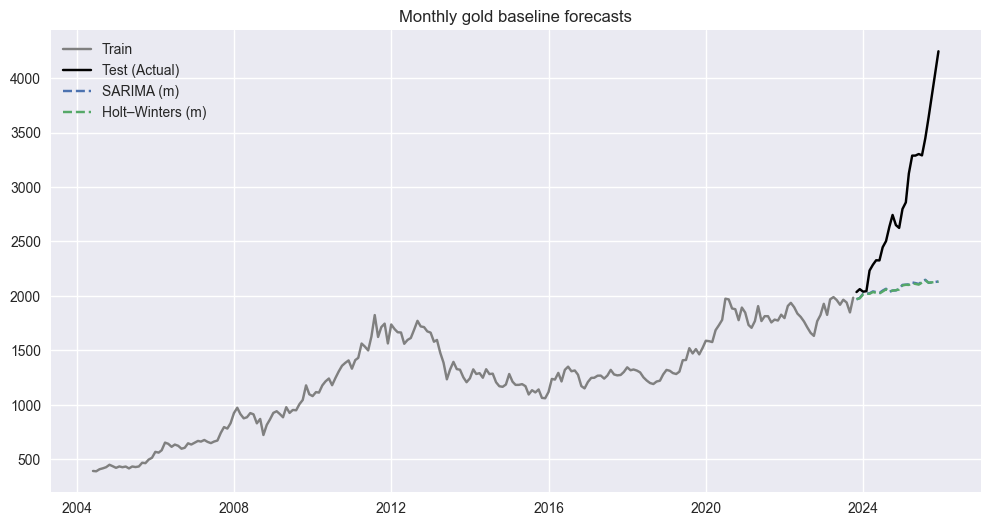

In [37]:
# Cell: monthly baselines and benchmarking
import warnings
warnings.filterwarnings("ignore")
# Use last 24 months for testing
train_m, test_m = time_split(close_m, test_size=24)

# SARIMA: simple starting point
sarima_m_res, sarima_m_pred = fit_sarima_forecast(train_m, test_m, order=(1,1,1), seasonal_order=(0,1,1,12))
sarima_m_metrics = evaluate_forecast(test_m, sarima_m_pred)

# Holt–Winters (additive)
hw_m_res, hw_m_pred = fit_holt_winters_forecast(train_m, test_m, trend="add", seasonal="add", seasonal_periods=12)
hw_m_metrics = evaluate_forecast(test_m, hw_m_pred)

print("Monthly SARIMA metrics:", sarima_m_metrics)
print("Monthly Holt–Winters metrics:", hw_m_metrics)

plot_forecasts(train_m, test_m,
               preds={"SARIMA (m)": sarima_m_pred, "Holt–Winters (m)": hw_m_pred},
               title="Monthly gold baseline forecasts")


## Daily Baseline Forecasting and Benchmarking (SARIMA vs Holt–Winters)
This cell benchmarks baseline forecasting models for the daily gold price series, using the most recent ~6 months (180 days) as the test set:

Train/Test Split: 
    The daily series is divided chronologically, with the last 180 days reserved for out‑of‑sample evaluation.   This ensures forecasts are validated against unseen data.

SARIMA Model: 
	A Seasonal ARIMA model is fit with parameters (p,d,q) = (1,1,1) and seasonal (P,D,Q,s) = (0,1,1,7).

	Weekly seasonality (s=7) is modeled to capture recurring weekly cycles.

	Yearly seasonality (s=365) is possible but computationally heavier.

	Forecasts are generated for the test horizon and aligned with actual dates.

Holt–Winters Model:
	A Triple Exponential Smoothing model with additive trend and weekly seasonality (seasonal_periods=7) is fit.

	Decomposes the series into level, trend, and seasonal components.

	Produces forecasts for the test horizon, aligned with the test index.

Evaluation Metrics: 
    Both models are benchmarked using MAE, RMSE, and MAPE to quantify forecast accuracy. Results are printed for comparison.

Visualization: 
	Forecasts from SARIMA and Holt–Winters are plotted alongside training and test data. This comparative plot highlights how well each baseline tracks actual daily gold price movements.

Conditional Execution: 
    If the daily dataset is not available, the analysis is skipped gracefully with a message, ensuring the notebook runs without errors.

This benchmarking step provides a baseline reference for daily forecasting, allowing comparison of statistical models before exploring more advanced approaches.

Daily SARIMA metrics: {'MAE': 505.8292103493088, 'RMSE': np.float64(561.0741569775636), 'MAPE': np.float64(15.34856366259912)}
Daily Holt–Winters metrics: {'MAE': 505.304613741266, 'RMSE': np.float64(560.5153465575501), 'MAPE': np.float64(15.332519567087811)}


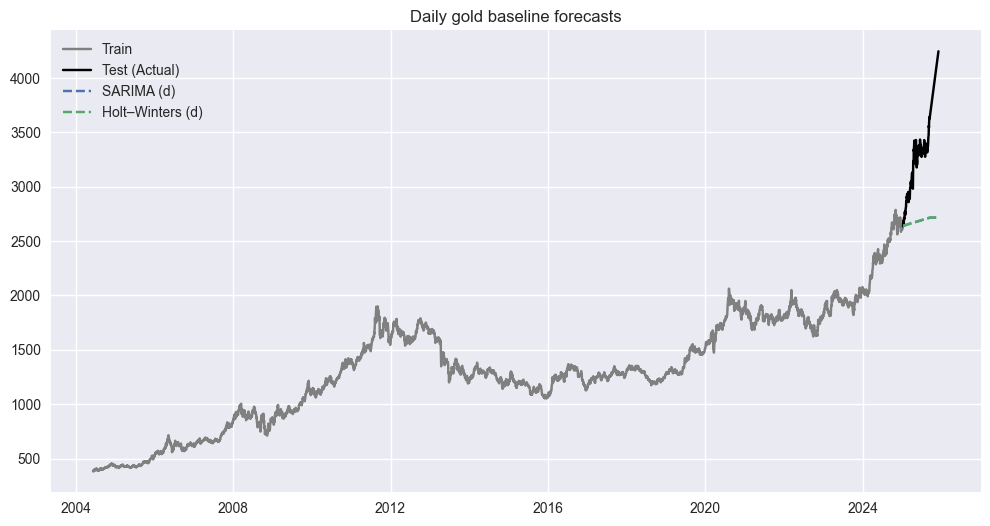

In [38]:
# Cell: daily baselines and benchmarking (skip if missing)
import warnings
warnings.filterwarnings("ignore")
if close_d is not None:
    # Test size ~6 months (adjust to taste)
    train_d, test_d = time_split(close_d, test_size=180)

    # SARIMA with weekly seasonality s=7 (fast); yearly s=365 is heavier
    sarima_d_res, sarima_d_pred = fit_sarima_forecast(train_d, test_d, order=(1,1,1), seasonal_order=(0,1,1,7))
    sarima_d_metrics = evaluate_forecast(test_d, sarima_d_pred)

    # Holt–Winters weekly seasonality
    hw_d_res, hw_d_pred = fit_holt_winters_forecast(train_d, test_d, trend="add", seasonal="add", seasonal_periods=7)
    hw_d_metrics = evaluate_forecast(test_d, hw_d_pred)

    print("Daily SARIMA metrics:", sarima_d_metrics)
    print("Daily Holt–Winters metrics:", hw_d_metrics)

    plot_forecasts(train_d, test_d,
                   preds={"SARIMA (d)": sarima_d_pred, "Holt–Winters (d)": hw_d_pred},
                   title="Daily gold baseline forecasts")
else:
    print("Daily baselines skipped: no daily dataset loaded.")


## Optional ML baseline: elastic net with lag features
A lightweight ML baseline using lag features can complement statistical baselines. We train on lagged monthly closes and predict out-of-sample via a recursive scheme.

Machine Learning Baseline with Lag Features (Monthly Gold Forecasting)
This cell introduces a machine learning baseline for forecasting monthly gold prices using lagged features and ElasticNet regression:

Lag Feature Construction (make_lag_features)

    Builds a supervised learning dataset where each target value 𝑦𝑡 is predicted from its past values 
    Creates 12 lag features to capture one full year of historical dependencies.
    Drops rows with missing values caused by shifting.

ElasticNet Regression (rolling_predict_elasticnet)

    Fits an ElasticNet model (combining L1 and L2 regularization) on the lagged training data.

    Uses a pipeline with StandardScaler for normalization and ElasticNet for regression.

    Parameters:

    alpha=0.1 controls overall regularization strength.

    l1_ratio=0.2 balances between L1 (sparsity) and L2 (ridge) penalties.

    Forecasting is recursive: predictions are generated step‑by‑step, each new forecast fed back into the lag history to predict the next point.

Evaluation and Benchmarking

    Forecasts are generated for the test horizon (last 24 months).

    Accuracy is measured using MAE, RMSE, and MAPE.

    Results are printed for comparison against statistical baselines.

Visualization (plot_forecasts)

    Plots training data, actual test values, and forecasts from three models:

        ElasticNet with lag features (ML baseline).

        SARIMA statistical baseline.

        Holt–Winters statistical baseline.

    Provides a direct visual comparison of machine learning vs traditional time series methods.

This step benchmarks a simple machine learning approach against classical statistical baselines, highlighting whether lag‑based regression can capture monthly gold price dynamics as effectively as SARIMA or Holt–Winters.

Monthly ElasticNet-lags metrics: {'MAE': 846.9435710816934, 'RMSE': np.float64(1027.6133821403564), 'MAPE': np.float64(27.756323171879526)}


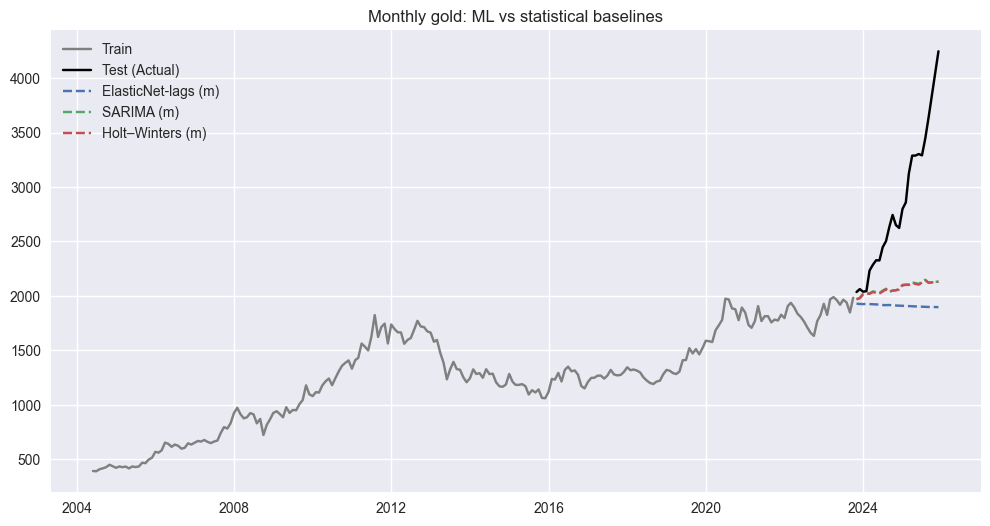

In [42]:
# Cell: ML baseline with lags (monthly)
def make_lag_features(series: pd.Series, lags=12) -> pd.DataFrame:
    """
    Create lag features X_t = [y_{t-1}, ..., y_{t-lags}] and target y_t.
    """
    df = pd.DataFrame({"y": series})
    for i in range(1, lags+1):
        df[f"lag_{i}"] = df["y"].shift(i)
    return df.dropna()

def rolling_predict_elasticnet(train: pd.Series, test: pd.Series, lags=12, alpha=0.1, l1_ratio=0.2):
    """
    Fit ElasticNet on lag features and produce recursive forecasts over the test horizon.
    """
    df_train = make_lag_features(train, lags=lags)
    X_train = df_train[[f"lag_{i}" for i in range(1, lags+1)]].values
    y_train = df_train["y"].values

    model = Pipeline([
        ("scaler", StandardScaler()),
        ("enet", ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, random_state=42))
    ])
    model.fit(X_train, y_train)

    # Recursive forecasting: start from the last lags in train
    history = list(train.iloc[-lags:].values)
    preds = []
    for _ in range(len(test)):
        x = np.array(history[-lags:])[::-1]  # lag_1 is last value
        x = x.reshape(1, -1)
        yhat = model.predict(x)[0]
        preds.append(yhat)
        history.append(yhat)

    pred_series = pd.Series(preds, index=test.index, name="enet_pred")
    return pred_series

# Run ML baseline on monthly data
enet_pred_m = rolling_predict_elasticnet(train_m, test_m, lags=12, alpha=0.1, l1_ratio=0.2)
enet_m_metrics = evaluate_forecast(test_m, enet_pred_m)

print("Monthly ElasticNet-lags metrics:", enet_m_metrics)

plot_forecasts(train_m, test_m,
               preds={"ElasticNet-lags (m)": enet_pred_m, "SARIMA (m)": sarima_m_pred, "Holt–Winters (m)": hw_m_pred},
               title="Monthly gold: ML vs statistical baselines")





In [43]:

print("=== Monthly Forecast Accuracy ===")
print("SARIMA:", evaluate_forecast(test_m, sarima_m_pred))
print("Holt-Winters:", evaluate_forecast(test_m, hw_m_pred))
print("ElasticNet:", evaluate_forecast(test_m, enet_pred_m))  # if ML model used
print("-----------------------------------------------------------------")
print("=== Daily Forecast Accuracy ===")
print("SARIMA:", evaluate_forecast(test_d, sarima_d_pred))
print("Holt-Winters:", evaluate_forecast(test_d, hw_d_pred))

=== Monthly Forecast Accuracy ===
SARIMA: {'MAE': 692.0667846482748, 'RMSE': np.float64(870.8979787085452), 'MAPE': np.float64(22.32372789315603)}
Holt-Winters: {'MAE': 695.812848505943, 'RMSE': np.float64(874.085610197274), 'MAPE': np.float64(22.4607906480793)}
ElasticNet: {'MAE': 846.9435710816934, 'RMSE': np.float64(1027.6133821403564), 'MAPE': np.float64(27.756323171879526)}
-----------------------------------------------------------------
=== Daily Forecast Accuracy ===
SARIMA: {'MAE': 505.8292103493088, 'RMSE': np.float64(561.0741569775636), 'MAPE': np.float64(15.34856366259912)}
Holt-Winters: {'MAE': 505.304613741266, 'RMSE': np.float64(560.5153465575501), 'MAPE': np.float64(15.332519567087811)}


In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# Actual direction
actual_dir_m = np.where(test_m.diff().fillna(0) > 0, 1, 0)

# Predicted direction
pred_dir_sarima_m = np.where(pd.Series(sarima_m_pred).diff().fillna(0) > 0, 1, 0)
pred_dir_holt_m = np.where(pd.Series(hw_m_pred).diff().fillna(0) > 0, 1, 0)

print("=== Monthly Direction Confusion Matrix (SARIMA) ===")
print(confusion_matrix(actual_dir_m, pred_dir_sarima_m))
print("Accuracy:", accuracy_score(actual_dir_m, pred_dir_sarima_m))

print("\n=== Monthly Direction Confusion Matrix (Holt-Winters) ===")
print(confusion_matrix(actual_dir_m, pred_dir_holt_m))
print("Accuracy:", accuracy_score(actual_dir_m, pred_dir_holt_m))


=== Monthly Direction Confusion Matrix (SARIMA) ===
[[ 2  4]
 [ 5 13]]
Accuracy: 0.625

=== Monthly Direction Confusion Matrix (Holt-Winters) ===
[[ 2  4]
 [ 7 11]]
Accuracy: 0.5416666666666666


In [45]:
actual_dir_d = np.where(test_d.diff().fillna(0) > 0, 1, 0)

pred_dir_sarima_d = np.where(pd.Series(sarima_d_pred).diff().fillna(0) > 0, 1, 0)
pred_dir_holt_d = np.where(pd.Series(hw_d_pred).diff().fillna(0) > 0, 1, 0)

print("=== Daily Direction Confusion Matrix (SARIMA) ===")
print(confusion_matrix(actual_dir_d, pred_dir_sarima_d))
print("Accuracy:", accuracy_score(actual_dir_d, pred_dir_sarima_d))

print("\n=== Daily Direction Confusion Matrix (Holt-Winters) ===")
print(confusion_matrix(actual_dir_d, pred_dir_holt_d))
print("Accuracy:", accuracy_score(actual_dir_d, pred_dir_holt_d))


=== Daily Direction Confusion Matrix (SARIMA) ===
[[28 47]
 [25 80]]
Accuracy: 0.6

=== Daily Direction Confusion Matrix (Holt-Winters) ===
[[28 47]
 [25 80]]
Accuracy: 0.6
